# Sentiment Analysis Using Various Approaches

In [1]:
import numpy as np 
import pandas as pd
import json
import time
import re
import seaborn as sns

# Text cleaning
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from nltk.stem import WordNetLemmatizer
import spacy 
nlp = spacy.load('en_core_web_sm')

# NLTK Bing Liu Lexicon 
import nltk
# nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize 

# VADER 
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, confusion_matrix

# Supervised learning 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC

from scipy.sparse import csr_matrix
from scipy.sparse import hstack, vstack

# Text Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pyplot as plt

# Topic Modeling 
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation

## Loading a subset of reviews and meta data

In [62]:
n = 1 
total_rows = 0

def process_chunks(file, chunksize = 1000):
    """
    Processes chunks of records from a JSON Lines file and appends them to a DataFrame.
    
    This function reads a JSON Lines file in chunks of a specified size, appends each chunk to a list of DataFrames, 
    and prints the number of rows added after processing each chunk. It stops after processing a maximum of 10 chunks.
    
    Parameters:
    file (str): The path to the JSON Lines file to be processed.
    chunksize (int): The number of records per chunk. Default is 1000.
    
    Returns:
    pd.DataFrame: A DataFrame containing all the processed chunks concatenated together.
    """

    # Setting as global variables
    global n, total_rows  
    
    chunks = pd.read_json(file, lines=True, chunksize = chunksize)
    dfs = []  
    n_chunks = 0

    for chunk in chunks:
        dfs.append(chunk)
        n_chunks += 1  
        print(len(chunk), " rows added")
        n += 1 
        total_rows += len(chunk)
        if n_chunks >= 10:  
            break  
            
    print("Done")
    print(f"Total rows: {total_rows}")
    return pd.concat(dfs, ignore_index=True)

In [3]:
reviews = "../data/Home_and_Kitchen.jsonl"
meta = "../data/meta_Home_and_Kitchen.jsonl"

start = time.process_time()

reviews_subset = process_chunks(reviews)

end = time.process_time()
elapsed_time = end - start
print('Created a subset of the reviews dataset')
print('Execution time:', elapsed_time, 'seconds')

print('--------------')
start = time.process_time()

meta_subset = process_chunks(meta)

end = time.process_time()
elapsed_time = end - start
print('Created a subset of the meta dataset')
print('Execution time:', elapsed_time, 'seconds')

1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
Done
Total rows: 10000
Created a subset of the reviews dataset
Execution time: 0.5 seconds
--------------
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
1000  rows added
Done
Total rows: 20000
Created a subset of the meta dataset
Execution time: 1.484375 seconds


## EDA

In [4]:
reviews_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             10000 non-null  int64         
 1   title              10000 non-null  object        
 2   text               10000 non-null  object        
 3   images             10000 non-null  object        
 4   asin               10000 non-null  object        
 5   parent_asin        10000 non-null  object        
 6   user_id            10000 non-null  object        
 7   timestamp          10000 non-null  datetime64[ns]
 8   helpful_vote       10000 non-null  int64         
 9   verified_purchase  10000 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 713.0+ KB


In [5]:
reviews_subset['rating'].value_counts()

rating
5    6821
4    1772
3     641
1     512
2     254
Name: count, dtype: int64

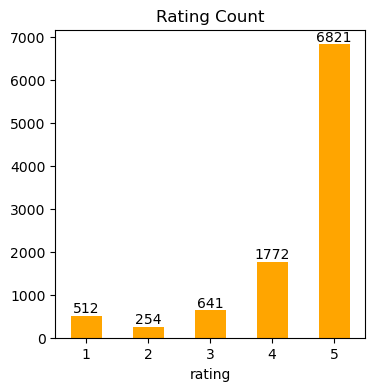

In [6]:
## Displays graphs directly within the notebook
%matplotlib inline 

ratings_count = reviews_subset.groupby('rating').size()

ax = ratings_count.plot(kind = 'bar', figsize = (4,4), color = 'orange')

ax.tick_params(axis='x', rotation=0)

# Add labels above the bars
for i in ax.containers:
    ax.bar_label(i)
    
ax.set_title('Rating Count');

### How many reviews are there per year?

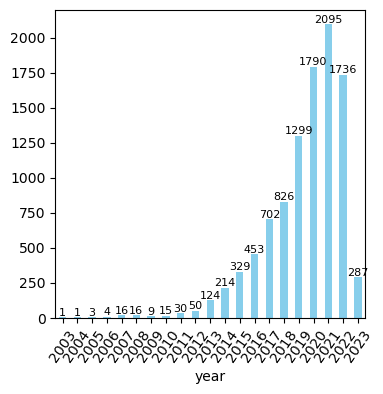

In [7]:
cleaned_text = reviews_subset.copy()

# Create a year column from the timestamp column 
cleaned_text['year'] = cleaned_text['timestamp'].dt.year

reviews_per_year = cleaned_text.groupby('year').size()
ax = reviews_per_year.plot(kind = 'bar', figsize = (4,4), color = 'skyblue')
ax.tick_params(axis='x', rotation=55)
for i in ax.containers:
    ax.bar_label(i, fontsize=8);


## Feature Engineering 

Create new features: word count, average word length, exclamation mark count, and sentiment.

In [63]:
def word_count(text):
    """
    Counts the number of words in the text.
    """
    words = text.split()
    return len(words)


def avg_word_length(text):
    """
    Returns the average word length in the text. 
    """
    # Check for empty or white-space only string 
    if not text.strip():
        return 0
        
    words = text.split()
    if not words:  # Check if words list is empty
        return 0
        
    word_lengths = [len(word) for word in words]
    avg_word_length = sum(word_lengths)/len(words)
    
    return(avg_word_length) 


def exclamation_count(text):
    """
    Returns the number of exclamations in the text.
    """
    doc = nlp(text)
    exclamations = []
    for token in doc: 
        if token.text == '!':
            exclamations.append(token.text)
    return len(exclamations)

In [9]:
cleaned_text['word_count'] = cleaned_text['text'].apply(word_count)
cleaned_text['avg_word_length'] = cleaned_text['text'].apply(avg_word_length)
cleaned_text['exclamation_count'] = cleaned_text['text'].apply(exclamation_count)

In [10]:
cleaned_text[['text', 'word_count', 'avg_word_length', 'exclamation_count']].head(3)

,text,word_count,avg_word_length,exclamation_count
0,Livid. Once again received an obviously used ...,28,4.678571,2
1,I purchased these for multiple reasons. The ma...,546,3.937729,0
2,[[VIDEOID:c87e962bc893a948856b0f1b285ce6cc]] I...,319,4.047022,0


In [11]:
cleaned_text['word_count'].describe()

count    10000.000000
mean        52.426600
std         60.472371
min          0.000000
25%         13.000000
50%         33.000000
75%         70.000000
max        708.000000
Name: word_count, dtype: float64

C:\Users\MJ\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


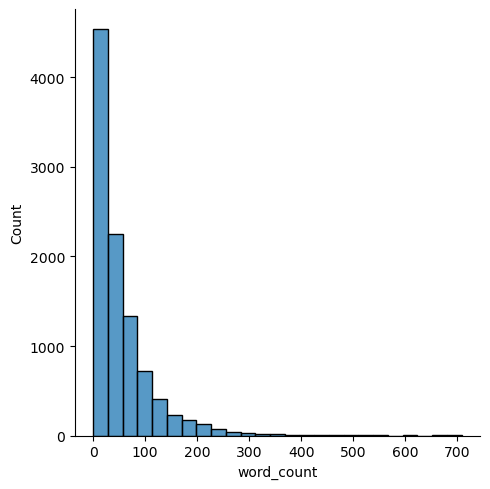

In [12]:
sns.displot(cleaned_text['word_count'],bins=25);

C:\Users\MJ\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


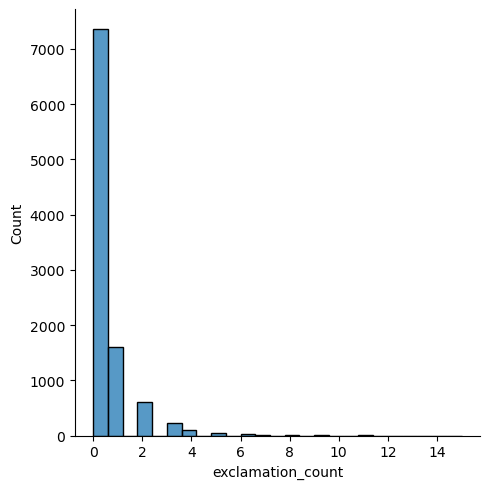

In [13]:
sns.displot(cleaned_text['exclamation_count'],bins=25);

## Text Cleaning - spaCy

In [14]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS
print('Original stopwords count:', len(stop_words))

# Updating my stopwords list 
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Include/ exclude certain words
include_stopwords = {'would', 'I'}
exclude_stopwords = {'i', 'well', 'off', 'very', 'not', 'few', 'much'}

stop_words |= include_stopwords
stop_words -= exclude_stopwords

# Remove adjectives from my stopwords using spaCy
exclude_adjectives = {word for word in stop_words if nlp(word)[0].pos_ == "ADJ"}
print(exclude_adjectives)

stop_words -= exclude_adjectives
print('Stopwords count:', len(stop_words))

Original stopwords count: 326
{'whole', 'empty', 'full', 'own', 'serious', 'third', 'many', 'same', 'latter', 'least', 'various', 'several', 'whereafter', 'top', 'former', 'such', 'other', 'due', 'last'}
Stopwords count: 301


In [64]:
def clean_data(doc):
    """
    Cleans and preprocesses a text document using spaCy.
    
    This function takes a text document as input, converts it to lowercase, 
    lemmatizes the words, removes non-alphabetic characters, and filters out stopwords. 
    The resulting cleaned text is returned as a single string. 
    """
    doc = doc.lower()
    doc = nlp(doc)
    # Lemmatize words 
    lemmas = [token.lemma_ for token in doc]
    # Removing non-alphabetic characters and stopwords
    tokens = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stop_words]
    cleaned_doc = " ".join(tokens)
    
    return cleaned_doc

cleaned_text['spacy_text'] = cleaned_text['text'].apply(clean_data)

In [66]:
i = 2
print(f'Title: {cleaned_text.loc[i,"title"]}\n')

print(f'Text: {cleaned_text.loc[i,"text"]}\n')

print(f'Text: {cleaned_text.loc[i,"spacy_text"]}\n')

Title: Lid very loose- needs a gasket imo. Small base.

Text: [[VIDEOID:c87e962bc893a948856b0f1b285ce6cc]] I wanted to love this bc I previously bought a matching turquoise teapot, but the loose lid (defective or design flaw? Idk) on the cups is driving me batty. I’m disabled so my gait is not great to begin with & the lid just bangs non-stop while I walk from my kitchen to wherever I’m going with my tea. It’s incredibly annoying.  I had hoped it was just a one-off so I purchased it in another color & sadly it has the same exact problem.  They could fix the problem by adding a rubber gasket or flange to the lid imo & I even thought of doing so myself until I accidentally knocked the cup over due to a design flaw that has a small base on the cup.  I like the lid bc I run a fan continuously & I live with 2 service dogs so I like to keep my drinks covered beyond just the brew times so I really hope they update this cup bc it does keep the tea warm & the size is perfect for a 2 cup brew.<b

## Sentiment Analysis with Lexicons

Unsupervised learning approach that involves evaluating the sentiment scores of words in a document based on predefined lexicons. A lexicon is a dictionary that contains a collection of words that is categorized as positive, negative, and neutral by experts. Each word's sentiment is determined, and the scores are combined to calculate the overall sentiment of the sentence. 
- Disadvantages: words that are not in the lexicon will not be scored; some lexicons might be better suited for a specific use; it overlooks negation (lexicons only match words and not phrases, ie "not bad" is scored more negative instead of neutral)

### Bing Liu Lexicon

The Bing Liu lexicon has a total of 6, 786 words with 2,005 classified as positive and 4,781 as negative. CLassification is binary (positive or negative).

In [17]:
print('Total number of words in opinion lexicon', len(opinion_lexicon.words()))
print('Examples of positive words:', opinion_lexicon.positive()[:10])
print('Examples of negative words:', opinion_lexicon.negative()[:10])

Total number of words in opinion lexicon 6789
Examples of positive words: ['a+', 'abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation']
Examples of negative words: ['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


In [18]:
pos_score = 1
neg_score = -1
word_dict = {}

# Adding the positive words to the dictionary
for word in opinion_lexicon.positive():
    word_dict[word] = pos_score 

# Adding the negative words to the dictionary 
for word in opinion_lexicon.negative():
    word_dict[word] = neg_score 

def bing_liu_score(text):
    sentiment_score = 0 
    bag_of_words = word_tokenize(text.lower())

    # Check if bag_of_words is empty
    if bag_of_words: 
        for word in bag_of_words: 
            if word in word_dict: 
                sentiment_score += word_dict[word]
        return sentiment_score / len(bag_of_words)
    else: 
        return 0

In [19]:
cleaned_text['Bing_Liu_score'] = cleaned_text['text'].apply(bing_liu_score)
cleaned_text['Bing_Liu_spaCy'] = cleaned_text['spacy_text'].apply(bing_liu_score)

### VADER Lexicon
Rule-based lexicon. 
9,000 features with scales of [-4] Extremely Negative to [4] Extremely Positive with [0] for Neutral or Neither. 

In [20]:
model = SentimentIntensityAnalyzer()

In [21]:
def vader_score(text):
    score = model.polarity_scores(text)
    compound_score = score['compound']
    return compound_score

In [22]:
cleaned_text['Vader_score'] = cleaned_text['text'].apply(vader_score)
cleaned_text['Vader_spaCy'] = cleaned_text['spacy_text'].apply(vader_score)

### Lexicon Sentiment Accuracy Scores 

In [23]:
cleaned_text[['Bing_Liu_score', 'Bing_Liu_spaCy', 'Vader_score', 'Vader_spaCy']].sample(3)

,Bing_Liu_score,Bing_Liu_spaCy,Vader_score,Vader_spaCy
8450,0.068966,0.153846,0.7003,0.7003
8822,0.142857,0.227273,0.9524,0.9524
9382,0.166667,0.333333,0.5859,0.5859


In [24]:
# Calculate mean sentiment score for each rating category
mean_scores = cleaned_text.groupby('rating').agg({
    'Bing_Liu_score':'mean',
    'Bing_Liu_spaCy': 'mean',
    'Vader_score': 'mean',
    'Vader_spaCy': 'mean'
}).reset_index()

print(mean_scores)

   rating  Bing_Liu_score  Bing_Liu_spaCy  Vader_score  Vader_spaCy
0       1       -0.031370       -0.063742    -0.115005    -0.038082
1       2        0.003011        0.004356     0.100559     0.156293
2       3        0.031123        0.062282     0.350320     0.365816
3       4        0.066978        0.143764     0.663724     0.645764
4       5        0.129455        0.249447     0.720333     0.710219


## Sentiment Analysis - Supervised Learning Approach

Using supervised learning models, we will classify the sentiment of a review based on pre-processed text from spaCy. Reviews will be classified as positive or negative sentiment based on their ratings:
- Positive (1): records with ratings of 4 and 5.
- Negative (0): records with ratings of 1 and 2.
- Neutral: records with ratings of 3 are removed.

### Feature Engineering: Sentiment Classification
Create a new column in our dataset to classify records based on our ratings. 

In [25]:
cleaned_text['sentiment'] = 0

# Classify records with rating higher than a 3, positive (1)
cleaned_text.loc[cleaned_text['rating'] > 3, 'sentiment'] = 1

# Classify records with rating lower than a 3, negative (0)
cleaned_text.loc[cleaned_text['rating'] < 3, 'sentiment'] = 0

# Remove records with a rating of 3
cleaned_text = cleaned_text.loc[cleaned_text['rating'] != 3].reset_index(drop=True)

In [26]:
# Remove observations that are empty after the cleaning step
cleaned_text = cleaned_text[cleaned_text['spacy_text'].str.len() != 0]
print('Record count:', len(cleaned_text))

Record count: 9351


### Text Vectorization with TF-IDF
Use TF-IDF vectorizer to transform the text into vectors based on the frequency of words in the text:

In [27]:
tfidf = TfidfVectorizer()
clf = MultinomialNB()

pipe = Pipeline([("tfidf", tfidf), ("clf", clf)])

param_grid = {
    'tfidf__ngram_range':[(1,1), (1,2), (1,3)],
    'tfidf__min_df':[1, 2, 5, 10, 20],
    'clf__fit_prior':[False, True]
}

### Model training and Evaluation
The following models will be used in our analysis:
- Logistic Regression: a linear model for binary classification.
- Linear Support Vector Classification (SVC): A classifier that constructs a hyperplane to separate classes.
- Randomized Search Cross-Validation: A technique to tune hyperparameters for improving model performance.

#### Randomized Search Cross Validation

In [29]:
X = cleaned_text[['spacy_text']]
y = cleaned_text['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [30]:
rs = RandomizedSearchCV(estimator = pipe, param_distributions = param_grid, verbose = 2, n_jobs = -1)
rs.fit(X_train['spacy_text'], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('clf', MultinomialNB())]),
                   n_jobs=-1,
                   param_distributions={'clf__fit_prior': [False, True],
                                        'tfidf__min_df': [1, 2, 5, 10, 20],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)]},
                   verbose=2)

In [31]:
y_pred = rs.predict(X_test['spacy_text'])

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.9363976483164084
ROC-AUC Score: 0.7182808707495416
Classification Report: 
               precision    recall  f1-score   support

           0       0.66      0.46      0.54       153
           1       0.95      0.98      0.97      1718

    accuracy                           0.94      1871
   macro avg       0.81      0.72      0.75      1871
weighted avg       0.93      0.94      0.93      1871

Confusion Matrix: 
 [[  70   83]
 [  36 1682]]


In [32]:
# Finding the best parameters 
print(rs.best_params_)
print(rs.best_score_)

{'tfidf__ngram_range': (1, 3), 'tfidf__min_df': 5, 'clf__fit_prior': False}
0.9367647058823529


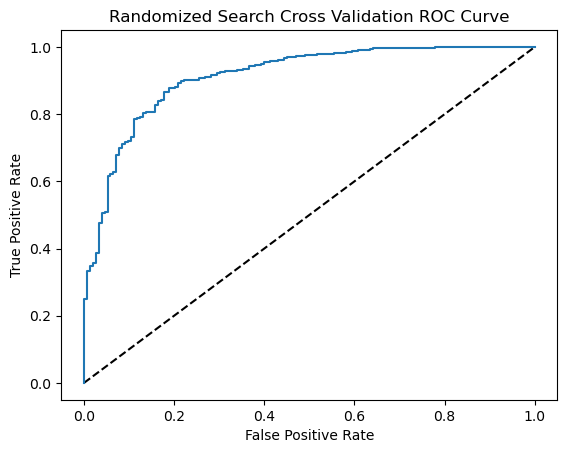

0.9118826420750683


In [33]:
sentiment_prob = rs.predict_proba(X_test['spacy_text'])
positive_class_prob = sentiment_prob[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, positive_class_prob, pos_label=1)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Randomized Search Cross Validation ROC Curve')
plt.show()

print(roc_auc_score(y_test, positive_class_prob))

#### Linear Support Vector Classification (SVC)

In [34]:
tfidf = TfidfVectorizer(min_df = 5, ngram_range = (1,3))

X_train_tf = tfidf.fit_transform(X_train['spacy_text'])
X_test_tf = tfidf.transform(X_test['spacy_text'])

linear = LinearSVC(random_state = 42, tol = 1e-5, max_iter = 10000)
linear.fit(X_train_tf, y_train)

LinearSVC(max_iter=10000, random_state=42, tol=1e-05)

In [35]:
y_pred = linear.predict(X_test_tf)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.9540352752538749
ROC-AUC Score: 0.7457466882756207
Classification Report: 
               precision    recall  f1-score   support

           0       0.89      0.50      0.64       153
           1       0.96      0.99      0.98      1718

    accuracy                           0.95      1871
   macro avg       0.93      0.75      0.81      1871
weighted avg       0.95      0.95      0.95      1871

Confusion Matrix: 
 [[  76   77]
 [   9 1709]]


### Logistic Regression

In [36]:
tfidf_log = TfidfVectorizer(min_df = 10, ngram_range = (1,3))

X_train_tf = tfidf_log.fit_transform(X_train['spacy_text'])
X_test_tf = tfidf_log.transform(X_test['spacy_text'])

logreg = LogisticRegression(max_iter = 1000).fit(X_train_tf, y_train)

In [37]:
y_pred = logreg.predict(X_test_tf)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.9374665954035275
ROC-AUC Score: 0.6265778721267319
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.25      0.40       153
           1       0.94      1.00      0.97      1718

    accuracy                           0.94      1871
   macro avg       0.93      0.63      0.68      1871
weighted avg       0.94      0.94      0.92      1871

Confusion Matrix: 
 [[  39  114]
 [   3 1715]]


In [38]:
features = None
features = tfidf_log.get_feature_names_out(features)

sentiment = 0
idx = list(logreg.classes_).index(sentiment)


# # Extract coefficients from the Logistic Regression model 
intercept = logreg.intercept_[idx]
coefficients = logreg.coef_[idx]

coefficients_df = pd.DataFrame({
    'variable': ['intercept'] + list(features),
    'coefficient': [intercept] + list(coefficients)
})

coefficients_df.sort_values(by = 'coefficient', ascending = False)


,variable,coefficient
1369,love,4.453039
957,great,3.958642
1540,nice,3.886642
653,easy,3.403961
1820,perfect,3.228035
...,...,...
2928,waste,-2.948213
305,cheap,-2.989884
585,disappointed,-3.408069
2132,return,-4.378082


### Train-Test Split with Other Features

In [39]:
cleaned_text.columns

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'year', 'word_count',
       'avg_word_length', 'exclamation_count', 'spacy_text', 'Bing_Liu_score',
       'Bing_Liu_spaCy', 'Vader_score', 'Vader_spaCy', 'sentiment'],
      dtype='object')

In [40]:
variables = ['rating', 'helpful_vote', 'verified_purchase', 'word_count', 'avg_word_length', 
            'exclamation_count', 'spacy_text', 'Bing_Liu_score', 'Bing_Liu_spaCy', 'Vader_score', 'Vader_spaCy']
X = cleaned_text[variables]
y = cleaned_text['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42, stratify = y)

In [41]:
print ('Size of Training Data ', X_train.shape[0])
print ('Size of Test Data ', X_test.shape[0])
print ('Distribution of classes in Training Data :')
print ('Positive Sentiment ', str(sum(y_train == 1)/ len(y_train) * 100.0))
print ('Negative Sentiment ', str(sum(y_train == 0)/ len(y_train) * 100.0))
print ('Distribution of classes in Testing Data :')
print ('Positive Sentiment ', str(sum(y_test == 1)/ len(y_test) * 100.0))
print ('Negative Sentiment ', str(sum(y_test == 0)/ len(y_test) * 100.0))


Size of Training Data  7480
Size of Test Data  1871
Distribution of classes in Training Data :
Positive Sentiment  91.81818181818183
Negative Sentiment  8.181818181818182
Distribution of classes in Testing Data :
Positive Sentiment  91.82255478353821
Negative Sentiment  8.177445216461784


### Model Testing

In [42]:
variables = ['helpful_vote', 'verified_purchase', 'word_count', 'avg_word_length', 
            'exclamation_count', 'Bing_Liu_score', 'Bing_Liu_spaCy', 'Vader_score', 'Vader_spaCy']
X_train[variables].astype(float)

,helpful_vote,verified_purchase,word_count,avg_word_length,exclamation_count,Bing_Liu_score,Bing_Liu_spaCy,Vader_score,Vader_spaCy
5851,0.0,0.0,73.0,4.849315,0.0,0.120482,0.243243,0.8555,0.8750
1409,4.0,1.0,40.0,4.100000,0.0,-0.022222,-0.153846,-0.6705,-0.7009
600,0.0,1.0,12.0,4.916667,0.0,0.375000,0.750000,0.8612,0.8612
5047,0.0,1.0,14.0,6.071429,0.0,0.000000,0.000000,0.2960,0.2960
7201,0.0,1.0,10.0,3.700000,0.0,0.166667,0.333333,0.2944,0.3520
...,...,...,...,...,...,...,...,...,...
1017,1.0,1.0,42.0,4.404762,0.0,0.021277,0.055556,0.6369,0.7269
6616,0.0,1.0,6.0,4.833333,0.0,-0.166667,-0.200000,0.4215,0.4215
208,0.0,1.0,39.0,4.435897,3.0,0.043478,0.150000,0.5033,0.7579
4907,0.0,0.0,31.0,4.612903,1.0,0.147059,0.266667,0.8353,0.9099


In [43]:
m = csr_matrix(X_train[variables].astype(float))
n = csr_matrix(X_test[variables].astype(float))

X_train_stack = hstack((m, X_train_tf))
X_test_stack = hstack((n, X_test_tf))

In [44]:
linear.fit(X_train_stack, y_train)

y_pred = linear.predict(X_test_stack)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')
print(f'Classification Report: \n {classification_report(y_test,y_pred, zero_division = 0.0)}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.9502939604489578
ROC-AUC Score: 0.7556171867272325
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.52      0.63       153
           1       0.96      0.99      0.97      1718

    accuracy                           0.95      1871
   macro avg       0.88      0.76      0.80      1871
weighted avg       0.95      0.95      0.95      1871

Confusion Matrix: 
 [[  80   73]
 [  20 1698]]


C:\Users\MJ\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Topic Modeling

Unsupervised NLP technique used to discover hidden topics in text documents.

**Singular Value Decomposition (SVD)**: 
- Aka Latent Semantic Indexing (LSI).
- Reduces dimensionality to reveal latent structures.

**Non-Negative Matrix Factorization (NMF)**
- Decomposes the term-document matrix into:
    - W (Document-Topic Matrix): Distribution of topics across documents.
    - H (Term-Topic Matrix): Significance of terms across topics.
- Advantages:
    - Easier interpretation due to non-negative values.
    - Higher scores indicate stronger relevance.

In [58]:
def display_topics(model, features, no_top_words=5):
    """
    Displays the top words for each topic in the given model.

    Parameters:
    model (sklearn.decomposition): The fitted topic model.
    features (list): The list of feature names (words) corresponding to the columns in the model's components_ attribute.
    no_top_words (int): The number of top words to display for each topic. Default is 5.
    """
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1]  # Invert sort order
        print(f"\nTopic {topic:02d}")  # Topic number
        for i in range(no_top_words):
            word = features[largest[i]]
            percentage_contribution = word_vector[largest[i]] * 100.0 / total
            print(f" {word} ({percentage_contribution:.2f}%)")

### SVD (Singular Value Decomposition)

In [59]:
svd_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components = 7))
])

svd_pipe.fit(cleaned_text['spacy_text'])
vocab = svd_pipe.named_steps['tfidf'].get_feature_names_out()
components = svd_pipe.named_steps['svd'].components_

In [60]:
topic_num = 0

pd.DataFrame({
    'word': vocab,
    'weight': components[topic_num]
}).sort_values('weight', ascending = False).head(10)

,word,weight
5920,product,0.614102
3232,good,0.569168
3312,great,0.174051
5070,not,0.159075
8401,very,0.126264
4435,love,0.126012
5019,nice,0.106471
8570,well,0.105487
4406,look,0.104913
8318,use,0.104904


In [61]:
display_topics(svd_pipe.named_steps['svd'], vocab)


Topic 00
 product (4.77%)
 good (4.43%)
 great (1.35%)
 not (1.24%)
 very (0.98%)

Topic 01
 product (-2.57%)
 good (-1.75%)
 wilton (-0.00%)
 communication (-0.00%)
 nespressos (-0.00%)

Topic 02
 love (-12.54%)
 great (-4.25%)
 beautiful (-0.99%)
 gift (-0.81%)
 product (-0.79%)

Topic 03
 great (-19.33%)
 work (-5.69%)
 price (-2.48%)
 product (-2.01%)
 look (-1.87%)

Topic 04
 nice (-8.75%)
 very (-5.96%)
 quality (-4.49%)
 look (-3.44%)
 soft (-2.24%)

Topic 05
 work (-17.04%)
 very (-14.96%)
 easy (-8.54%)
 well (-7.29%)
 clean (-4.99%)

Topic 06
 perfect (-45.47%)
 good (-22.35%)
 work (-21.45%)
 well (-10.56%)
 size (-8.98%)


### NMF (Non-negative Matrix Factorization)

In [53]:
nmf_pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF(n_components = 7))
])

nmf_pipe.fit(cleaned_text['spacy_text'])

nmf_vocab = nmf_pipe.named_steps['tfidf'].get_feature_names_out()
nmf_components = nmf_pipe.named_steps['nmf'].components_

In [54]:
topic_num = 3

pd.DataFrame({
    'word': nmf_vocab,
    'weight': nmf_components[topic_num]
}).sort_values('weight', ascending = False).head(10)

,word,weight
3312,great,2.878234
5879,price,0.453298
4406,look,0.347344
6020,quality,0.241452
8348,value,0.165066
2359,easy,0.161163
5920,product,0.141740
957,buy,0.141271
6160,recommend,0.117322
3171,gift,0.097055


In [55]:
display_topics(nmf_pipe.named_steps['nmf'], vocab)


Topic 00
 product (42.79)
 good (36.51)
 quality (1.18)
 price (0.62)
 excellent (0.26)

Topic 01
 not (1.99)
 use (1.30)
 like (0.93)
 review (0.77)
 easy (0.74)

Topic 02
 love (26.60)
 beautiful (1.99)
 color (1.67)
 gift (1.65)
 buy (1.48)

Topic 03
 great (24.45)
 price (3.85)
 look (2.95)
 quality (2.05)
 value (1.40)

Topic 04
 nice (6.15)
 very (5.78)
 look (2.79)
 quality (2.65)
 soft (1.87)

Topic 05
 work (19.99)
 well (9.43)
 perfectly (1.63)
 need (1.23)
 expect (0.87)

Topic 06
 perfect (19.21)
 size (4.58)
 need (2.17)
 fit (1.96)
 gift (1.27)
